实验名称：NTK_Frequency_Sweep_v1  
实验日期：2026-01-07  
参考文献：Fourier Features Let Networks Learn High Frequency Functions in Low Dimensional Domains  
实验目的：复现论文中的figuer2（b）,figuer3，验证p值减小时，高频分量的收敛速度是否会加快  
commit：  


In [77]:
# environment
import numpy as np
from scipy.fft import ifft
import jax
import jax.numpy as jnp
import haiku as hk # Haiku是JAX的一个神经网络库
import matplotlib.pyplot as plt
import optax # Optax是JAX的一个优化器库

In [2]:
print(type(ifft(np.array([2,2]))))


<class 'numpy.ndarray'>


In [3]:


def generate_1f_noise_signal(c=8,n=32,alpha=1):
    cn = c * n
    # 1. 采样高斯向量
    gaussian_vector = np.random.randn(cn)

    # 2. 频率缩放
    # 注意：这里i的范围和具体实现可能需要调整，取决于你如何定义频率索引
    # 论文中提到 j = 1, ..., n/2，所以这里可能需要更精细的频率处理
    scaled_vector = np.zeros(cn, dtype=complex)

    for i in range(1, cn // 2 + 1): # 假设对称频率
        scaled_vector[i] = gaussian_vector[i] / (i**alpha)
        if i > 0 and i < cn - i: # 确保共轭对称
            scaled_vector[cn - i] = np.conj(scaled_vector[i])
    
    # 3. 逆傅里叶变换
    signal = ifft(scaled_vector)
    
    # 4. 取实部
    return np.real(signal)

target_function = generate_1f_noise_signal(c=8,n=32,alpha=1)
print(target_function.shape)


(256,)


In [11]:
# prepare datasets
c = 8
n =32
cn = c*n
# 1. 采样点
x_full = np.linspace(0, 1, cn, endpoint=False) # 在[0, 1)上均匀采样cn个点
y_full = target_function # 对应的函数值

# 2. 训练集和测试集
# 假设训练集有32个点，你可以随机选择，或者均匀选择
num_train_points = 32
# 均匀选择训练点
train_indices = np.linspace(0, cn - 1, num_train_points, dtype=int)

test_indices = np.array([i for i in range(cn) if i not in train_indices])

x_train = x_full[train_indices]
y_train = y_full[train_indices]

x_test = x_full[test_indices]
y_test = y_full[test_indices]

In [104]:
def mlp_model(x):
    net = hk.Sequential([
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1024), jax.nn.relu,
        hk.Linear(1) # 输出层，因为是拟合1D函数，所以输出是1维
    ])
    return net(x)

rng = jax.random.PRNGKey(42) # 随机数种子
mlp_transformed = hk.without_apply_rng(hk.transform(mlp_model))



In [92]:
jnp.concatenate([x_train[:,None], jnp.cos(2 * jnp.pi * x_train[:,None])], axis=-1).shape

(32, 2)

In [103]:
print("JAX default backend:", jax.default_backend())
print("Available devices:", jax.devices())

JAX default backend: cpu
Available devices: [CpuDevice(id=0)]


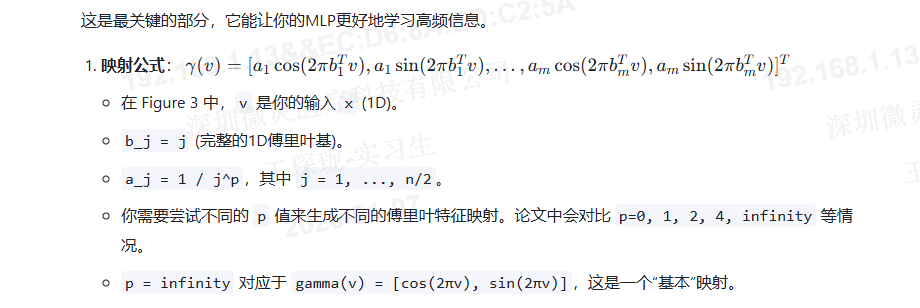

In [93]:
# achieve fourier feature mappin
def fourier_feature_mapping(x, num_frequencies, p_value):
    """
    args:
        x 是你的输入，形状 (batch_size, 1)
        n_freqs 对应论文中的 n/2，即傅里叶基的数量
        p_value 是你要调整的参数
        
    return:
        傅里叶特征映射后的结果，形状为 (train_points, 2*num_frequencies)
    """
    if p_value == float('inf'):
        return jnp.concatenate([jnp.cos(2 * jnp.pi * x), jnp.sin(2 * jnp.pi * x)], axis=-1)

    features = []
    # 计算 2*num_frequencies 个频率的余弦和正弦
    for j in range(1, num_frequencies+1):
        a_j = 1 / j**p_value
        b_j = j
        features.append(a_j * jnp.cos(2 * jnp.pi * b_j* x)) # 是如何进行傅里叶变换的
        features.append(a_j* jnp.sin(2 * jnp.pi * b_j * x))
    
    # 拼接余弦和正弦特征
    return jnp.concatenate(features, axis=-1)

mapped_x_train_p0 = fourier_feature_mapping(x_test[:, None], num_frequencies=n//2, p_value=0)
mapped_x_train_p1 = fourier_feature_mapping(x_train[:, None], num_frequencies=n//2, p_value=1)
mapped_x_train_p2 = fourier_feature_mapping(x_train[:, None], num_frequencies=n//2, p_value=2)

In [94]:
print(mapped_x_train_p0[:,0].shape)


(224,)


(-1.0, 1.0)

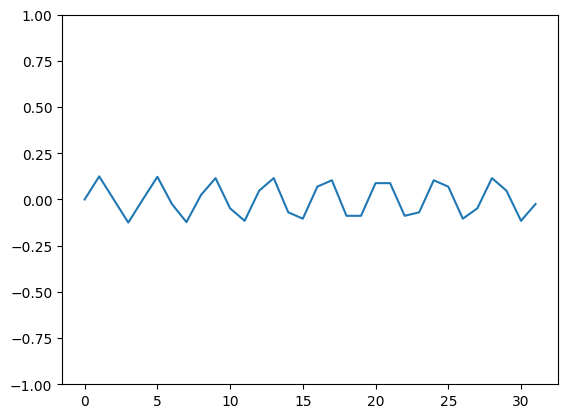

In [95]:

# plt.imshow(mapped_x_train_p0)
plt.plot(mapped_x_train_p1[:,15])
plt.ylim(-1, 1)


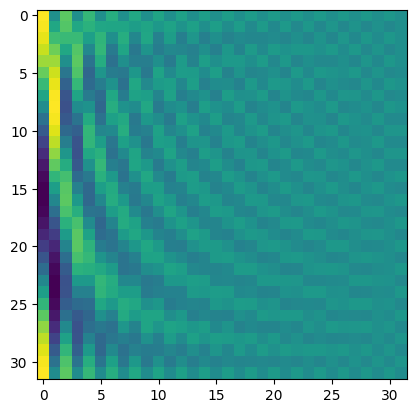

In [96]:
plt.imshow(mapped_x_train_p1)


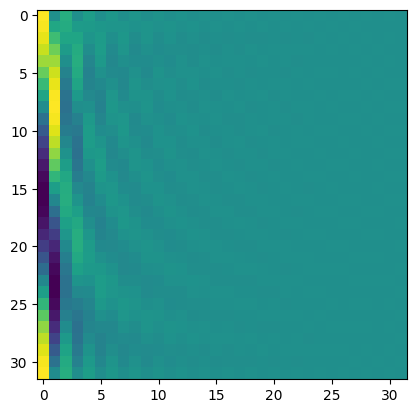

In [97]:
plt.imshow(mapped_x_train_p2)


In [111]:
# train model
from functools import partial
# 损失函数
def mse_loss(params, model_apply, x, y):
    predictions = model_apply(params, x)
    return jnp.mean((predictions - y)**2)

# 训练步骤
# 使用JIT编译，加速计算
@partial(jax.jit, static_argnums=(2, 5))
def train_step(params, opt_state, model_apply, x, y, optimizer):
    loss_value, grads = jax.value_and_grad(mse_loss)(params, model_apply, x, y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

# 完整的训练循环（伪代码）
def run_training(p_value, x_train, y_train, x_test, y_test, num_iterations=5000, learning_rate=1e-4):
    # 1. 初始化MLP参数
    params = mlp_transformed.init(rng, x_train) # 传入一个示例输入来初始化参数 x_train.shape: (32,)

    # 2. 初始化优化器
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)

    train_losses = []
    test_losses = []

    for step in range(num_iterations):
        # 应用傅里叶特征映射
        mapped_x_train = fourier_feature_mapping(x_train[:, None], num_frequencies=n//2, p_value=p_value)
        mapped_x_test = fourier_feature_mapping(x_test[:, None], num_frequencies=n//2, p_value=p_value)

        # 训练一步
        params, opt_state, current_train_loss = train_step(
            params, opt_state, mlp_transformed.apply, mapped_x_train, y_train[:, None], optimizer
        )
        train_losses.append(current_train_loss)

        # 计算测试损失
        test_predictions = mlp_transformed.apply(params, mapped_x_test)
        current_test_loss = jnp.mean((test_predictions - y_test[:, None])**2)
        test_losses.append(current_test_loss)

        if step % 500 == 0:
            print(f"p={p_value}, Step {step}, Train Loss: {current_train_loss:.4f}, Test Loss: {current_test_loss:.4f}")
            
    return train_losses, test_losses, params

In [112]:
# 假设你已经为不同的p值运行了训练，并得到了 train_losses_pX 和 test_losses_pX

p_values_to_test = [0, 1, 2, 4, 100] # 论文中可能测试的p值

all_train_losses = {}
all_test_losses = {}


for p_val in p_values_to_test:
    print(f"--- Training for p = {p_val} ---")
    train_l, test_l, final_params = run_training(p_val, x_train, y_train, x_test, y_test, num_iterations=5000)
    all_train_losses[p_val] = train_l
    all_test_losses[p_val] = test_l



--- Training for p = 0 ---
p=0, Step 0, Train Loss: 0.0061, Test Loss: 0.0499
p=0, Step 500, Train Loss: 0.0000, Test Loss: 0.0003
p=0, Step 1000, Train Loss: 0.0000, Test Loss: 0.0003
p=0, Step 1500, Train Loss: 0.0000, Test Loss: 0.0003
p=0, Step 2000, Train Loss: 0.0000, Test Loss: 0.0003
p=0, Step 2500, Train Loss: 0.0000, Test Loss: 0.0003
p=0, Step 3000, Train Loss: 0.0000, Test Loss: 0.0003
p=0, Step 3500, Train Loss: 0.0000, Test Loss: 0.0003
p=0, Step 4000, Train Loss: 0.0000, Test Loss: 0.0003
p=0, Step 4500, Train Loss: 0.0000, Test Loss: 0.0003
--- Training for p = 1 ---
p=1, Step 0, Train Loss: 0.0010, Test Loss: 0.0022
p=1, Step 500, Train Loss: 0.0000, Test Loss: 0.0000
p=1, Step 1000, Train Loss: 0.0000, Test Loss: 0.0000
p=1, Step 1500, Train Loss: 0.0000, Test Loss: 0.0000
p=1, Step 2000, Train Loss: 0.0000, Test Loss: 0.0000
p=1, Step 2500, Train Loss: 0.0000, Test Loss: 0.0000
p=1, Step 3000, Train Loss: 0.0000, Test Loss: 0.0000
p=1, Step 3500, Train Loss: 0.0000, 

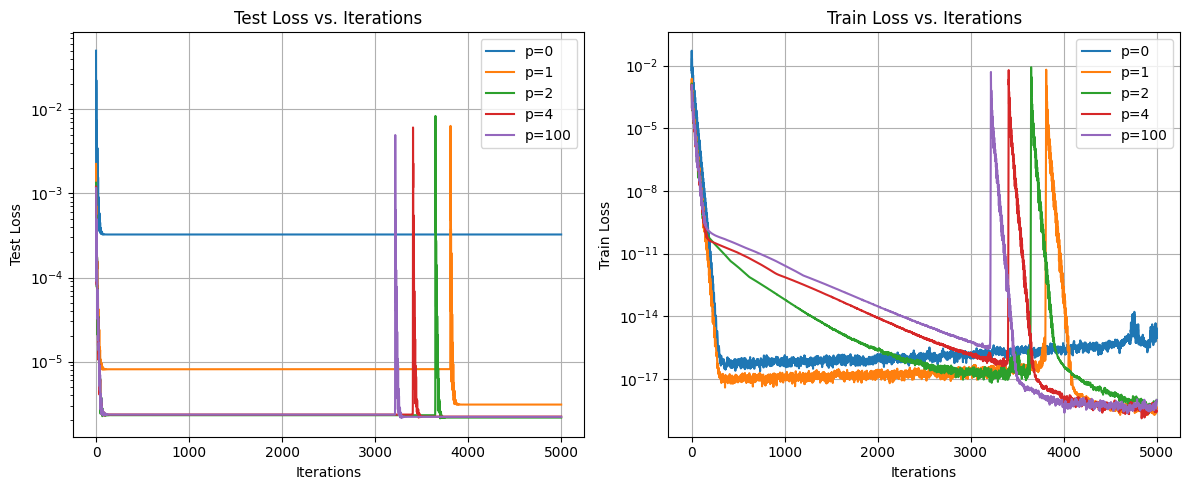

In [113]:
# visualize
# 绘制 Figure 3b (测试损失) 和 Figure 3d (训练损失)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # Figure 3b: Test Loss
for p_val, losses in all_test_losses.items():
    label = f'p={p_val}' if p_val != float('inf') else 'p=inf (Basic)'
    plt.plot(losses, label=label)
plt.xlabel("Iterations")
plt.ylabel("Test Loss")
plt.yscale("log") # 损失通常用对数尺度显示
plt.title("Test Loss vs. Iterations")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) # Figure 3d: Train Loss
for p_val, losses in all_train_losses.items():
    label = f'p={p_val}' if p_val != float('inf') else 'p=inf (Basic)'
    plt.plot(losses, label=label)
plt.xlabel("Iterations")
plt.ylabel("Train Loss")
plt.yscale("log")
plt.title("Train Loss vs. Iterations")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 对于 Figure 3c (训练损失频率分量)，这需要使用 Neural Tangents 库来计算NTK，
# 然后进行特征值分解。这部分会更复杂，需要深入了解NTK的理论和库的使用。
# 简而言之，你需要：
# 1. 使用 nt.empirical_ntk_fn 或 nt.predict.gradient_descent 来计算NTK
# 2. 对NTK矩阵进行特征值分解
# 3. 分析不同频率分量（对应于NTK的特征向量）的收敛速度
# 这超出了一个“傻瓜式”教程的范围，但如果你能完成前面的步骤，可以深入研究Neural Tangents的文档。